# Описание набора данных

Данные описывают кварталы города Екатеринбург с рассчитанными метриками, такими как:


*   Процент незастроенной площади в квартале - free_area_percent
*   Расстояние от квартала до ближайшей рекреационной территории - nearest_distance
*   Количество объектов культуры в 20 минутной доступности - culture_count

С помощью кластеризации предполагается выделить типы городских кварталов для принятия управленческих решений и формирования грдостроительной политики.




In [ ]:
#https://www.iaacblog.com/programs/k-means-clustering-for-urban-typologies/

# Загрузка и предварительная обработка данных

Импортируем библиотеки

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [ ]:
!pip install geopandas
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install numpy==1.22.0  # какие-то проблемы с зависимостямя
!pip install geopandas mapclassify  # mapclassify для визуализации

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install keplergl  # для визуализации
from keplergl import KeplerGl
from google.colab import output
output.enable_custom_widget_manager()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install geojson
from geojson import Feature, FeatureCollection, dump

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Загрузим данные в датафрейм

In [ ]:
#df = pd.read_csv("/content/cityblocks_for_clusters (1).csv", index_col = 1)

Окинем взглядом основные статистики, посчитанные по данному набору данных.

In [ ]:
gdf = gpd.read_file('/content/cityblocks_metric.geojson')
gdf.set_index('area', inplace=True)

In [ ]:
gdf_geometry = gdf.loc[:, ['geometry', 'people']]

In [ ]:
gdf.explore()

In [ ]:
df= gdf.loc[:, ['freeareapercent', 'nearest_distance', 'culture_count']]

In [ ]:
df

freeareapercent  nearest_distance  culture_count
area                                                        
177839.801            5.443        201.213103            NaN
352204.484            9.001         75.407288            NaN
24999.179             3.189        469.513151            NaN
368831.846            5.166         74.165243            NaN
24070.968             6.242        552.798932            NaN
...                     ...               ...            ...
94039.818             5.309         29.064138            NaN
20361.749             5.569         38.393261            NaN
87598.820            29.817        117.276610            NaN
23839.925            10.627       7120.208566            NaN
74289.693            19.500       6681.353159            NaN

[1053 rows x 3 columns]

In [ ]:
df.describe()

freeareapercent  nearest_distance  culture_count
count      1053.000000       1053.000000     142.000000
mean          7.196650       2476.623540       2.485915
std           5.974761       1991.234871       1.636186
min           2.008000          0.000000       1.000000
25%           4.719000        986.107132       1.000000
50%           5.784000       2171.544369       2.000000
75%           7.576000       3416.145454       4.000000
max         132.140000      11848.617736       5.000000

В столбце culture_count заполним значения Null на 0, так как Null означает, что в радиусе доступности для данного квартала отсутствуютт сервисы культуры



In [ ]:
df['culture_count'].fillna(0, inplace=True)

In [ ]:
df

freeareapercent  nearest_distance  culture_count
area                                                        
177839.801            5.443        201.213103            0.0
352204.484            9.001         75.407288            0.0
24999.179             3.189        469.513151            0.0
368831.846            5.166         74.165243            0.0
24070.968             6.242        552.798932            0.0
...                     ...               ...            ...
94039.818             5.309         29.064138            0.0
20361.749             5.569         38.393261            0.0
87598.820            29.817        117.276610            0.0
23839.925            10.627       7120.208566            0.0
74289.693            19.500       6681.353159            0.0

[1053 rows x 3 columns]

<Axes: >

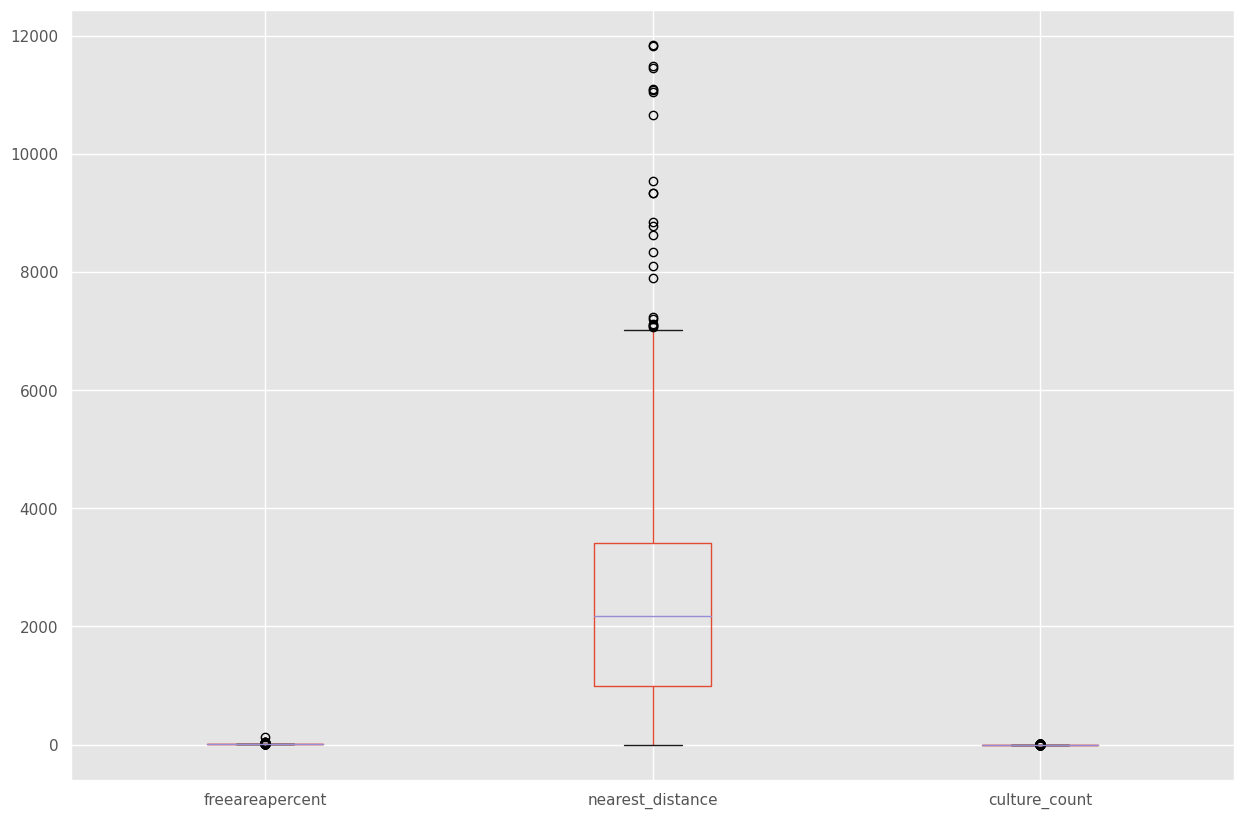

In [ ]:
df.boxplot(figsize=(15,10))

<Axes: >

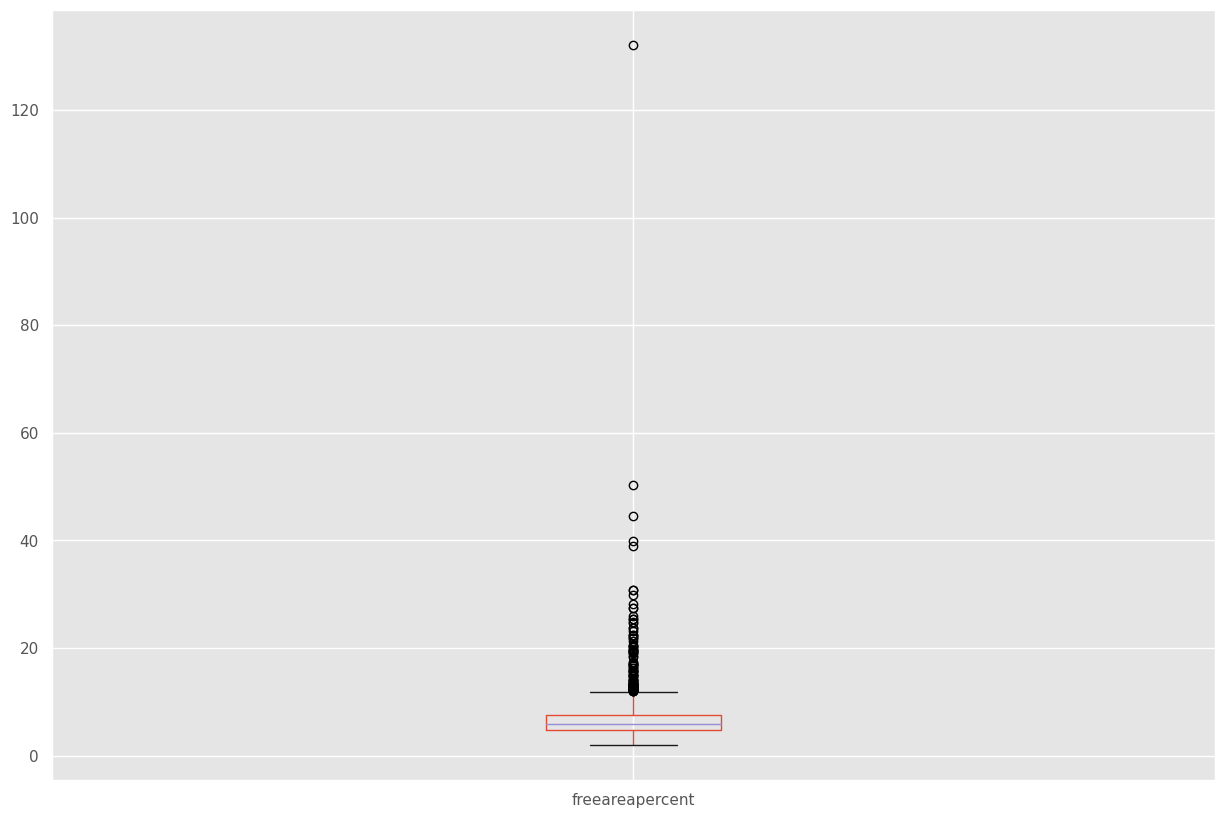

In [ ]:
df.loc[:, ['freeareapercent']].boxplot(figsize=(15,10))

Можно наблюдать большое количество выбросов в столбце freeareapercent, которые представляют из себя кварталы с очень низким процентом застройки. Такие кварталы не совсем подходят для целей исседования, поэтому можем от них избавиться.

In [ ]:
df = df[df['freeareapercent'] <= 10]

<Axes: >

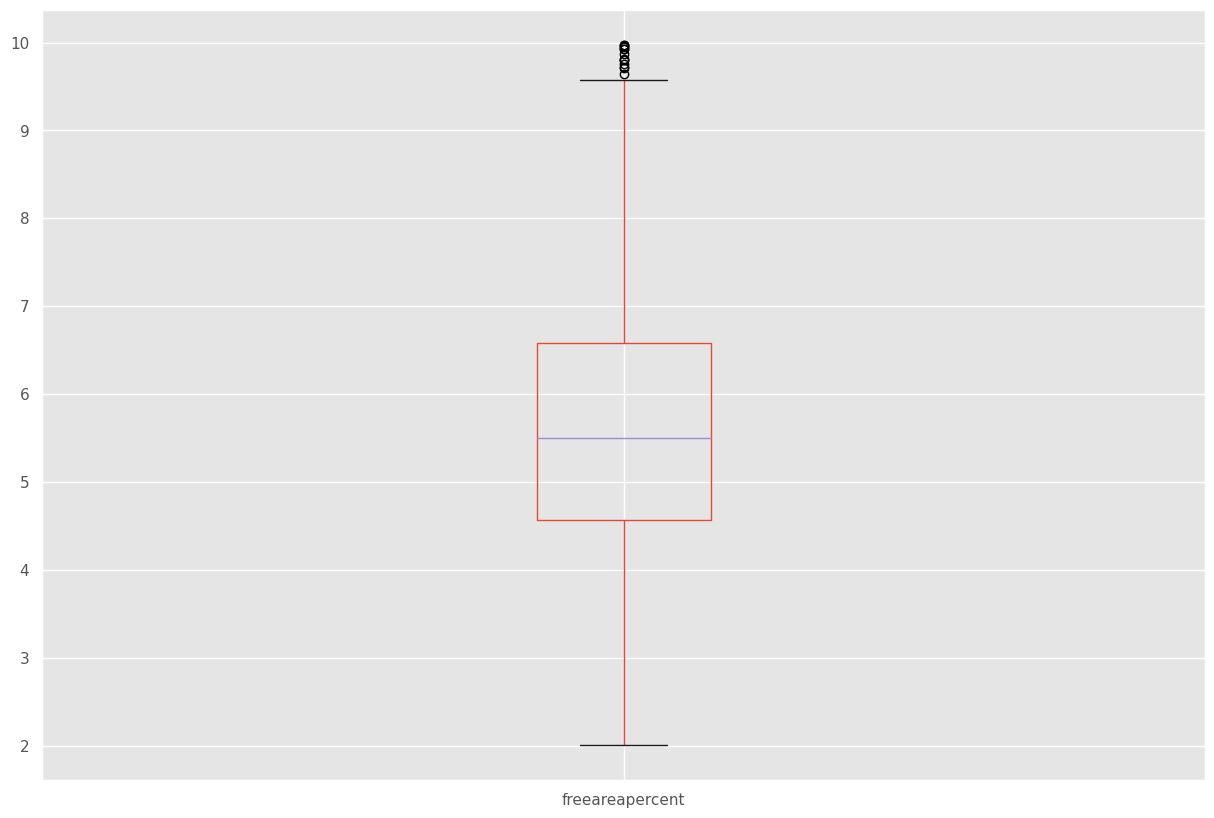

In [ ]:
df.loc[:, ['freeareapercent']].boxplot(figsize=(15,10))

Видно, что выбросы удалены. Этот же график показывает, что рассматриваемые числовые величины имеют разный порядок, а значит, без сомнений, перед началом обработки их нужно стандартизировать. Будем стандартизировать с помощью StandartScaler().

In [ ]:
standard_scaler = StandardScaler()
standard_df = pd.DataFrame(data = standard_scaler.fit_transform(df), index = df.index, columns = df.columns)
standard_df

freeareapercent  nearest_distance  culture_count
area                                                        
177839.801        -0.160784         -1.259846      -0.340197
352204.484         2.065432         -1.327661      -0.340197
24999.179         -1.571096         -1.115221      -0.340197
368831.846        -0.334101         -1.328330      -0.340197
24070.968          0.339145         -1.070326      -0.340197
...                     ...               ...            ...
46782.744         -0.906610         -0.964481      -0.340197
66310.280         -0.783974         -0.928049      -0.340197
31584.795         -1.089313         -1.044914      -0.340197
94039.818         -0.244627         -1.352642      -0.340197
20361.749         -0.081947         -1.347613      -0.340197

[911 rows x 3 columns]

Снова взглянем на boxplot, чтобы убедиться, что теперь визуально все неплохо.

In [ ]:
standard_df

freeareapercent  nearest_distance  culture_count
area                                                        
177839.801        -0.160784         -1.259846      -0.340197
352204.484         2.065432         -1.327661      -0.340197
24999.179         -1.571096         -1.115221      -0.340197
368831.846        -0.334101         -1.328330      -0.340197
24070.968          0.339145         -1.070326      -0.340197
...                     ...               ...            ...
46782.744         -0.906610         -0.964481      -0.340197
66310.280         -0.783974         -0.928049      -0.340197
31584.795         -1.089313         -1.044914      -0.340197
94039.818         -0.244627         -1.352642      -0.340197
20361.749         -0.081947         -1.347613      -0.340197

[911 rows x 3 columns]

<Axes: >

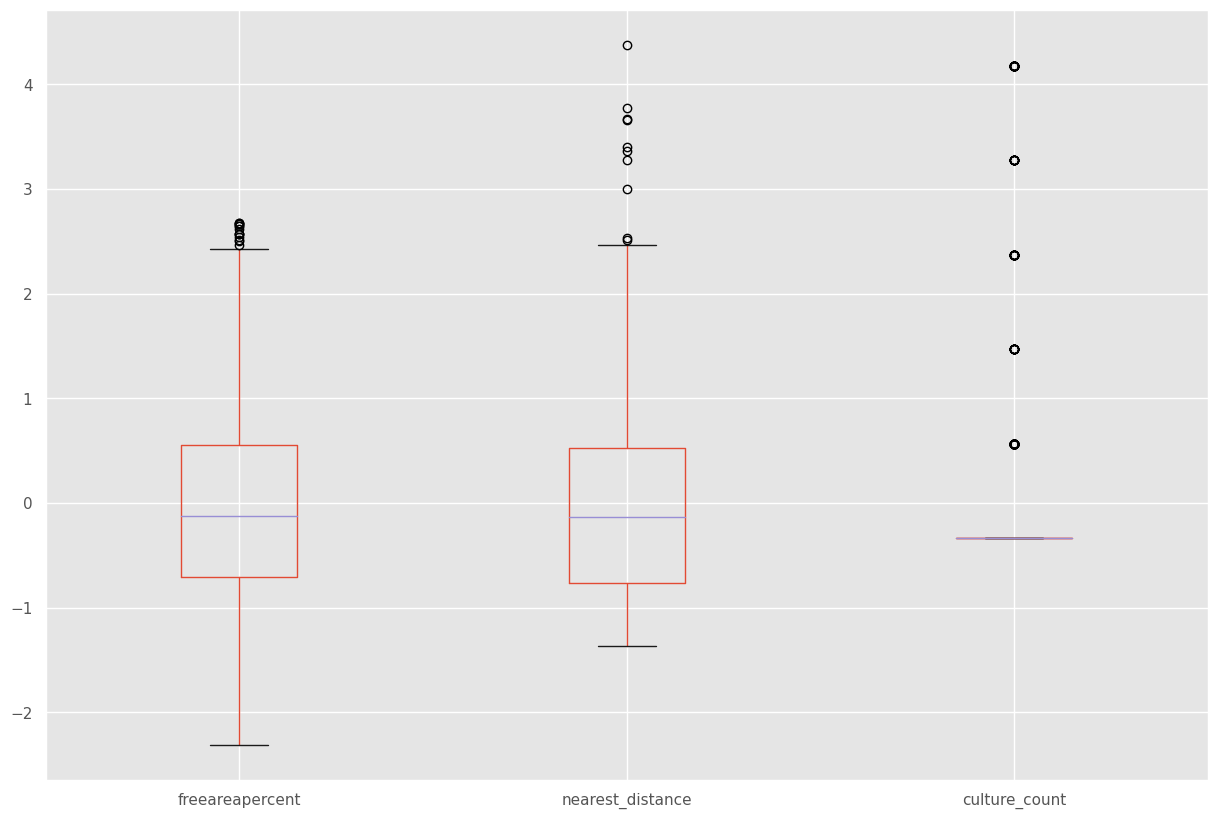

In [ ]:
standard_df.boxplot(figsize=(15,10))

Мы видим, что теперь все величины имеют одинаковый порядок. Есть, конечно, выбивающееся значение в `nearest_distance` и `freeareapercent`, но оно не кажется аномальным. `culture_count` не распределена нормально, но это не является проблемой, такова специфика этой метрики.

Теперь данные подготовленны и можно идти дальше.

# Постановка задачи и построение модели

Наша задача — выяснить, могут ли предложенные данные быть разбиты каким-то образом на группы (кластеризованы), и, в случае утвердительного ответа,  определить смысл полученных групп.

Для проведения кластеризации будем использовать метод k-means. Попытаемся определить адекватное число кластеров (изучим диапазон от 1 до 10).

In [ ]:
final_df = df

In [ ]:
final_df

freeareapercent  nearest_distance  culture_count
area                                                        
177839.801            5.443        201.213103            0.0
352204.484            9.001         75.407288            0.0
24999.179             3.189        469.513151            0.0
368831.846            5.166         74.165243            0.0
24070.968             6.242        552.798932            0.0
...                     ...               ...            ...
46782.744             4.251        749.156667            0.0
66310.280             4.447        816.742634            0.0
31584.795             3.959        599.942961            0.0
94039.818             5.309         29.064138            0.0
20361.749             5.569         38.393261            0.0

[911 rows x 3 columns]

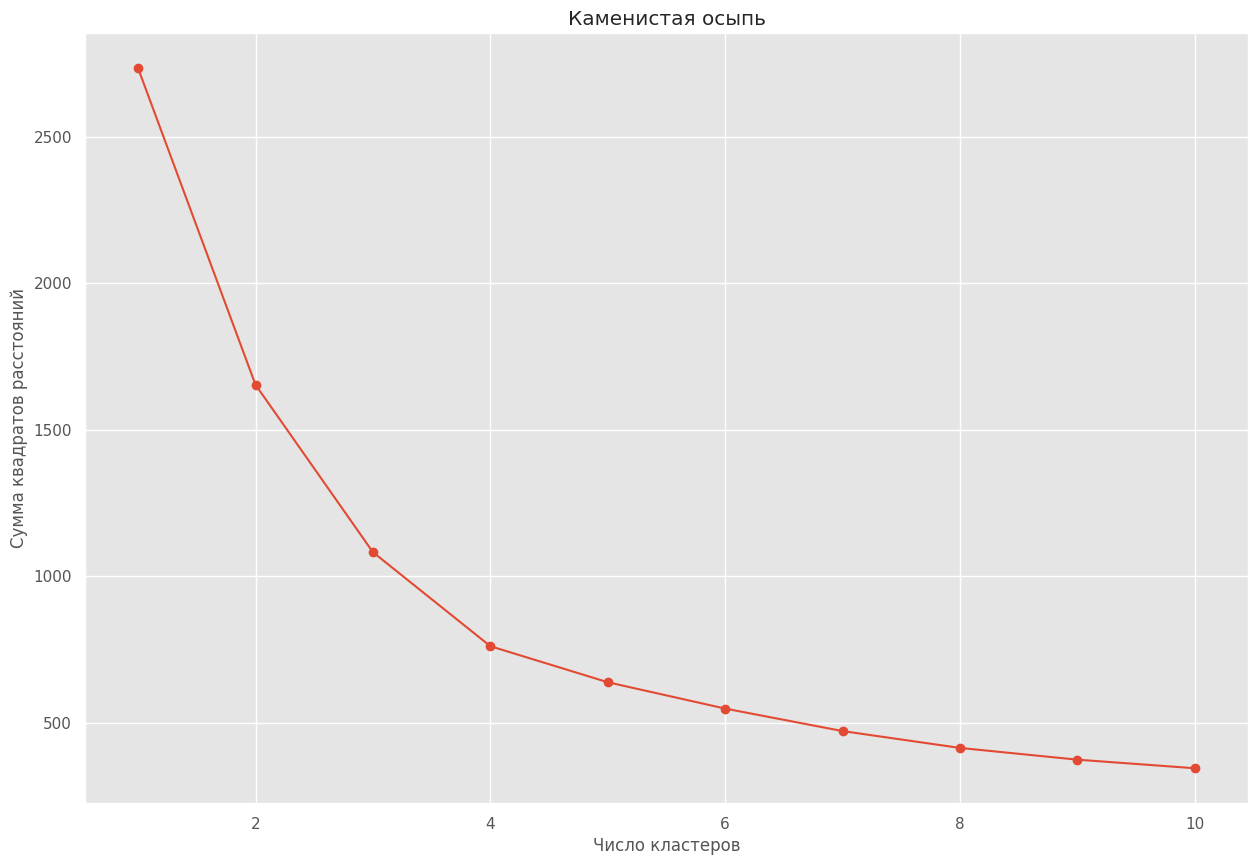

In [ ]:
K = range(1, 11)
models = [KMeans(n_clusters = k, random_state = 111, n_init = 100, max_iter = 10000).fit(standard_df) for k in K]
dist = [model.inertia_ for model in models]

plt.figure(figsize=(15,10))
plt.plot(K, dist, marker='o')
plt.xlabel('Число кластеров')
plt.ylabel('Сумма квадратов расстояний')
plt.title('Каменистая осыпь')
plt.show()

По графику видно, что имеет смысл рассмотреть диапазон от 2 до 5 кластеров. Далее излом не такой большой, а значит большее количество кластеров можно не брать в расчет.

Произведем кластеризацию для каждого случая и визуализируем полученные результаты.

In [ ]:
matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

sns.set(style = "darkgrid")


<ipython-input-182-fe52cb17f87d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[f'{i}_clusters'] = model.labels_


            freeareapercent  nearest_distance  culture_count
2_clusters                                                  
0                  5.860842       2304.585603       0.087678
1                  3.673448       5483.821880       4.014925


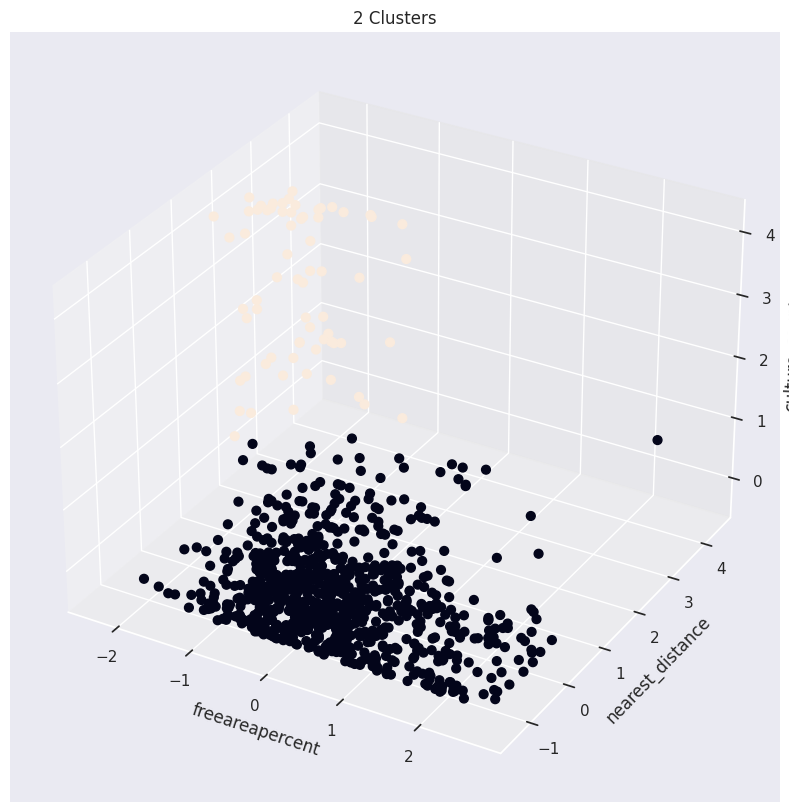

<ipython-input-182-fe52cb17f87d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[f'{i}_clusters'] = model.labels_


            freeareapercent  nearest_distance  culture_count
3_clusters                                                  
0                  4.865031       2976.498178       0.118998
1                  7.157077       1427.537798       0.051913
2                  3.679273       5519.164443       4.045455


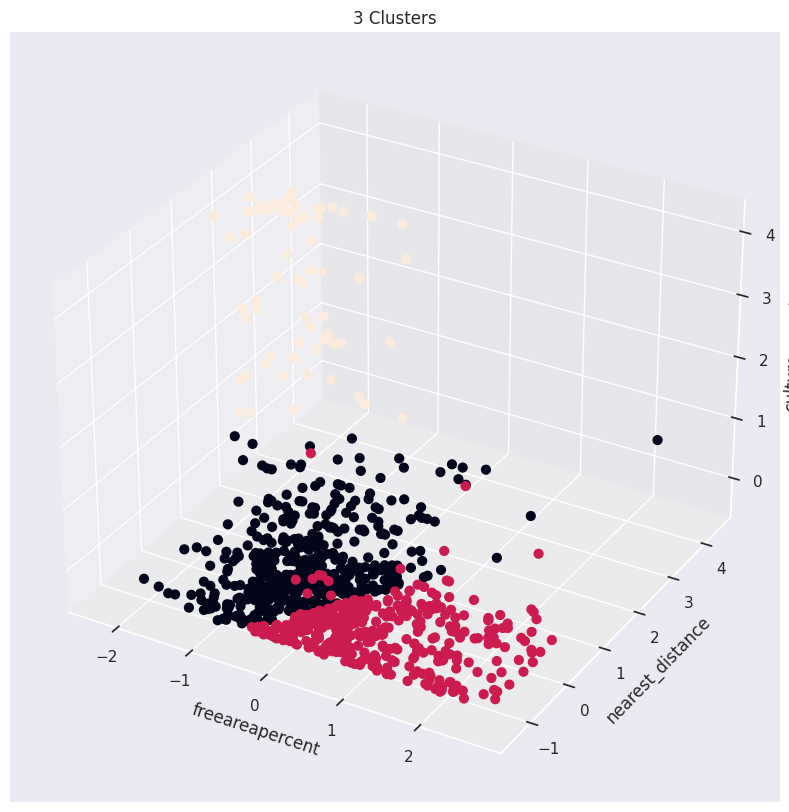

<ipython-input-182-fe52cb17f87d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[f'{i}_clusters'] = model.labels_


            freeareapercent  nearest_distance  culture_count
4_clusters                                                  
0                  5.255309       1434.255581       0.062814
1                  3.657587       5515.124180       4.142857
2                  5.007496       4327.290598       0.196721
3                  8.003893       1642.431379       0.043689


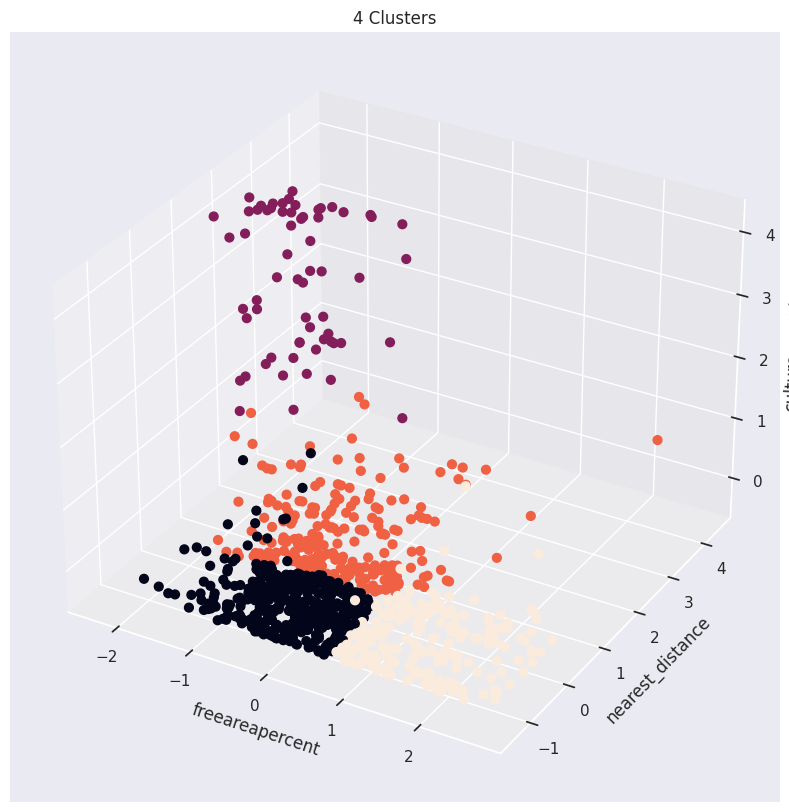

<ipython-input-182-fe52cb17f87d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df[f'{i}_clusters'] = model.labels_


            freeareapercent  nearest_distance  culture_count
5_clusters                                                  
0                  8.131893       1777.937881       0.048128
1                  5.492365       1123.160500       0.053892
2                  3.655444       5477.182797       4.142857
3                  5.025580       6198.877059       0.246377
4                  4.885659       3225.160042       0.147287


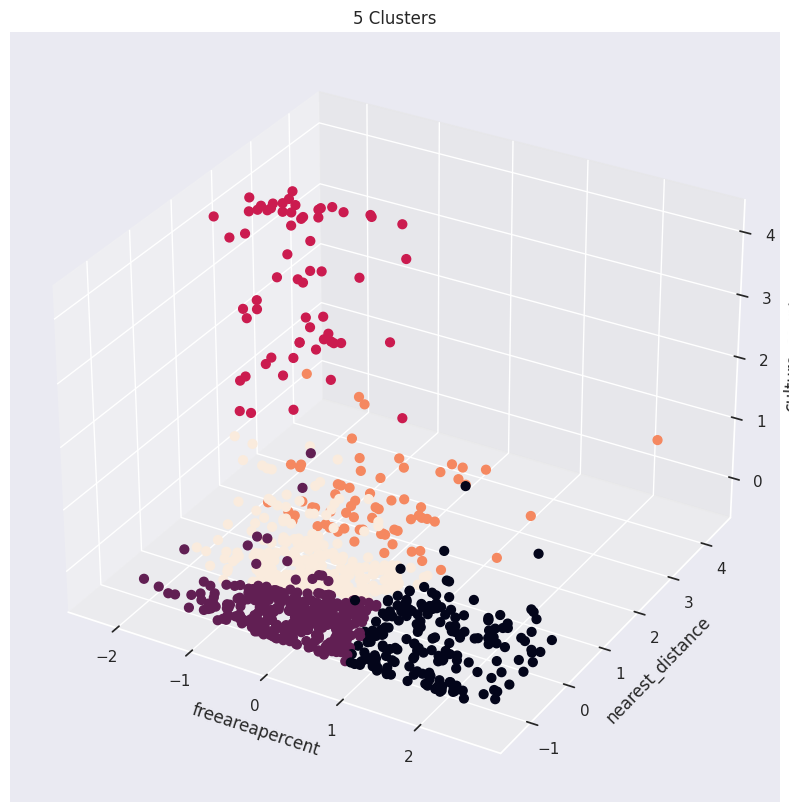

In [ ]:
for i in range(2,6):
  model = KMeans(n_clusters = i, random_state = 111, n_init = 100, max_iter = 10000)
  model.fit(standard_df)

  final_df[f'{i}_clusters'] = model.labels_

  print(final_df.groupby(f'{i}_clusters')[['freeareapercent','nearest_distance','culture_count']].mean())

  threedee = plt.figure(figsize=(15,10)).add_subplot(111, projection='3d')
  threedee.scatter(standard_df["freeareapercent"], standard_df["nearest_distance"], standard_df["culture_count"], c = final_df[f'{i}_clusters'], alpha = 1, s =40)
  threedee.set_xlabel('freeareapercent')
  threedee.set_ylabel('nearest_distance')
  threedee.set_zlabel('culture_count')
  threedee.set_title(f'{i} Clusters')
  plt.show()

По построенным моделям можно предположить, что разбиения на 4 кластера является наиболее удачным и интерпретируемым. Более мелкое разбиение размывает четкие границы кластеров.

In [ ]:
final_df

freeareapercent  nearest_distance  culture_count  2_clusters  \
area                                                                       
177839.801            5.443        201.213103            0.0           0   
352204.484            9.001         75.407288            0.0           0   
24999.179             3.189        469.513151            0.0           0   
368831.846            5.166         74.165243            0.0           0   
24070.968             6.242        552.798932            0.0           0   
...                     ...               ...            ...         ...   
46782.744             4.251        749.156667            0.0           0   
66310.280             4.447        816.742634            0.0           0   
31584.795             3.959        599.942961            0.0           0   
94039.818             5.309         29.064138            0.0           0   
20361.749             5.569         38.393261            0.0           0   

            3_clusters  4_clusters  5_clusters  
area                                            
177839.801           1           0           1  
352204.484           1           3           0  
24999.179            0           0           1  
368831.846           1           0           1  
24070.968            1           0           1  
...                ...         ...         ...  
46782.744            0           0           1  
66310.280            0           0           1  
31584.795            0           0           1  
94039.818            1           0           1  
20361.749            1           0           1  

[911 rows x 7 columns]

In [ ]:
gdf_geometry

geometry
area                                                         
177839.801  POLYGON ((60.51253 56.78819, 60.51285 56.78819...
352204.484  POLYGON ((60.49822 56.78989, 60.49823 56.78989...
24999.179   POLYGON ((60.52061 56.79220, 60.52061 56.79221...
368831.846  POLYGON ((60.50796 56.79517, 60.50811 56.79508...
24070.968   POLYGON ((60.48738 56.79776, 60.48738 56.79776...
...                                                       ...
94039.818   POLYGON ((60.70510 56.74876, 60.70536 56.74863...
20361.749   POLYGON ((60.70359 56.74930, 60.70359 56.74930...
87598.820   POLYGON ((60.70450 56.74656, 60.70499 56.74630...
23839.925   POLYGON ((60.73948 56.70401, 60.73988 56.70372...
74289.693   POLYGON ((60.73942 56.70405, 60.73942 56.70405...

[1053 rows x 1 columns]

In [ ]:
cityblocks_clusters = gdf_geometry.merge(final_df, on='area', how='right')

# Оценка модели и результатов

Проведем финальную кластеризацию и интерпретируем результаты

In [ ]:
cityblocks_clusters.groupby('4_clusters')[['freeareapercent','nearest_distance','culture_count']].mean()

freeareapercent  nearest_distance  culture_count
4_clusters                                                  
0                  5.255309       1434.255581       0.062814
1                  3.657587       5515.124180       4.142857
2                  5.007496       4327.290598       0.196721
3                  8.003893       1642.431379       0.043689

При разбиении на 4 кластера, интерпретация самая наглядная.
*   Нулевой кластер — это кварталы со средней плотностью застройки, хорошим доступом к рекреационным зонам и почти не обеспеченные объектами культуры. Отлично характеризуют окраинные районы города.
*   Первый кластер — достаточно плотная застройка с низкой доступностью рекреации и высокой доступностью объектов культуры. Отлично выделяется самый центр города.
*   Второй кластер — это кварталы со средней плотностью застройки, со средним доступом к рекреационным зонам и почти не обеспеченные объектами культуры.
*   Третий кластер — кварталы с очень низкой плотностью застройки, с хорошим доступом к рекреационным зонам и не обеспеченные объектами культуры. Эти кварталы наименее "городские" и представляют собой нечто вроде субурбии.

In [ ]:
map = KeplerGl(height=1000) # визуализируем в кеплер
map.add_data(data=cityblocks_clusters.copy(), name='Cityblocks')
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Cityblocks': {'index': [177839.801, 352204.484, 24999.179, 368831.846, 24070.968, 10007.311, 1…

In [ ]:
cityblocks_clusters.to_file("cityblocks_metric.geojson", driver="GeoJSON")

Имеет смысл выделить 4 кластера. Это оптимальный вариант для интерпретации и подходит для дальнейшего анализа.